<a href="https://colab.research.google.com/github/Wesley-Janson/transformers_for_human_vs_ai_text_identification/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import relevant packages and data_loader.py
#import data_loader

# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
import matplotlib.pyplot as plt

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv1d, Conv2d, MaxPool1d, MaxPool2d, Module, Softmax, BatchNorm1d, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torchtext.data.utils import get_tokenizer
from sklearn.model_selection import train_test_split

In [2]:
import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import pandas as pd

In [3]:
def load_data(csv):
  # Reads the raw csv file and split into
  # sentences (x) and target (y)
  df = pd.read_csv(csv)  
  text = df['intro'].values
  labels = df['type'].values
  return labels,text


In [4]:

# This function processes training data, establishing number IDs for each vocabulary word,
# converting word sequence into ID sequence (input_as_ids), and providing dict
# to map from word to its ID (word2id), and list to map from ID back to word (id2word)
def process_training_data(corpus_text):
        """Tokenizes a text file."""
        # Create the model's vocabulary and map to unique indices
        word2id = {}
        id2word = []
        indexes_dropped = []
        list_of_inputs = []
        for j, entry in enumerate(corpus_text):
            for i,word in enumerate(entry):
                if 7<i<=30:
                    if word not in word2id:
                        id2word.append(word)
                        word2id[word] = len(id2word) - 1

            # Convert string of text into string of IDs in a tensor for input to model
            input_as_ids = []
            for i,word in enumerate(entry):
                if 7<i<=30:
                    input_as_ids.append(word2id[word])
            if len(input_as_ids) == 23:
              list_of_inputs.append(input_as_ids)
            else:
              indexes_dropped.append(j)
            # final_ids = torch.LongTensor(input_as_ids)
        list_of_inputs = torch.Tensor(list_of_inputs)

        return list_of_inputs,word2id,id2word, indexes_dropped

In [5]:
# Run data loader
labels, text = load_data('data.csv')
small_labels = labels[:1000]
small_text = text[:1000]
train_x, val_x, train_y, val_y = train_test_split(small_text, small_labels, test_size = 0.2)

tokenizer = get_tokenizer("basic_english")
print(len(train_x))
list_of_tokens_train = [tokenizer(x) for x in train_x]
list_of_tokens_val = [tokenizer(x) for x in val_x]

train_x,word2id,id2word, indexes_dropped_train = process_training_data(list_of_tokens_train)

val_x,word2id,id2word, indexes_dropped_val = process_training_data(list_of_tokens_val)


800


In [6]:
new_train = [x for x in indexes_dropped_train]
new_val = [x for x in indexes_dropped_val]
train_y = list(train_y)
for index, element in enumerate(new_train):
  train_y = train_y[:indexes_dropped_train[index]] + train_y[indexes_dropped_train[index]+1:]
  for i in range(len(indexes_dropped_train)):
    indexes_dropped_train[i] -= 1
for index, element in enumerate(new_val):
  val_y = list(val_y[:indexes_dropped_val[index]]) + list(val_y[indexes_dropped_val[index]+1:])
  for i in range(len(indexes_dropped_val)):
    indexes_dropped_train[i] -= 1
train_y = np.asarray(train_y)
val_y = np.asarray(val_y)
train_y = torch.Tensor(train_y.reshape((len(train_y), 1)))
val_y = torch.Tensor(val_y.reshape((len(val_y), 1)))
print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)

torch.Size([794, 23])
torch.Size([794, 1])
torch.Size([199, 23])
torch.Size([199, 1])


In [7]:
# from torchtext.data.utils import get_tokenizer
# from torchtext.vocab import build_vocab_from_iterator
# labels,text = load_data('data.csv')
# train_x, val_x, train_y, val_y = train_test_split(text, labels, test_size = 0.8)

# tokenizer = get_tokenizer('basic_english')

# def yield_tokens(data_iter):
#     for text in data_iter:
#         yield tokenizer(text)

# vocab = build_vocab_from_iterator(yield_tokens(train_x), specials=["<unk>"])
# vocab.set_default_index(vocab["<unk>"])

In [8]:
text_pipeline = lambda x: x
label_pipeline = lambda x: int(x)
train_both = np.concatenate([train_x,train_y], axis = 1)
val_both = np.concatenate([val_x,val_y], axis = 1)
print(train_both.shape)
print(type(train_both))

(794, 24)
<class 'numpy.ndarray'>


In [9]:
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for entry in batch:
         _label = entry[-1] 
         _text = entry[:len(entry)-1] 
         label_list.append(label_pipeline(_label))
         processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)
batch_size_var = 10
train_loader = DataLoader(train_both, batch_size=batch_size_var, shuffle=False, collate_fn=collate_batch)
val_loader = DataLoader(train_both, batch_size=batch_size_var, shuffle=False, collate_fn=collate_batch)
trainSteps = len(train_loader.dataset) // batch_size_var
valSteps = len(val_loader.dataset) // batch_size_var
for i, batch in enumerate(train_loader):
  a,b,c = batch
  if len(a) != 10:
      print(i, batch)


79 (tensor([1, 1, 1, 1]), tensor([  19,   14,   15, 1687, 1346,   17, 4116,   19,   14, 4117, 1074,    5,
          15, 4118, 4119,   89,   15, 4120, 2044,   14,   15, 4121, 1537,   12,
         700,    0,    8,   30,  759, 1287,   26,    4,    5,    9,   14,  130,
          19, 4122,   41,  119, 1285, 1577,   14, 2395,   14,   15,  595,    0,
           1,   30, 1949,  564,  400,  324,   15, 4123, 2542,  761,  923, 4124,
           0,    5,  127,  565,   75,   15, 1950, 1518,   17, 4125,   10,   77,
         944,   14,  900,    5,   15, 2450,   17,   15, 2449,    8,  959,    5,
        1229,   26,   54,  136,  229, 4126, 1842,  644]), tensor([ 0, 23, 46, 69]))


In [10]:
next_, labels_, _offset = next(iter(train_loader))
print(next_)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


In [11]:
# Define Architecture

class CNN(Module):   
    def __init__(self):
        super(CNN, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv1d(10, 4000, kernel_size=3, stride=1, padding=1),
            BatchNorm1d(23),
            ReLU(inplace=True),
            MaxPool1d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv1d(4000, 10, kernel_size=3, stride=1, padding=1),
            BatchNorm1d(11),
            ReLU(inplace=True),
            MaxPool1d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(5, 1)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x.float())
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [12]:
# defining the model
model = CNN()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.001)
# defining the loss function
criterion = torch.nn.BCEWithLogitsLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

CNN(
  (cnn_layers): Sequential(
    (0): Conv1d(10, 4000, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(23, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(4000, 10, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): BatchNorm1d(11, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=5, out_features=1, bias=True)
  )
)


In [13]:
#logistic regression bag of words, can get fwearture importance

#how get feature importance in CNN's

#how get tokesn out of featurs

#run examples we know, print which filter getting trigegred, associate words or grams with filteere

#tsney (visualize nerual net)

#take examples human got wrong, see what we get right, find k-grams that ar enon-triavail

In [14]:
# Create train function
def train_epoch(epoch):
    running_loss = 0
    last_loss = 0

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_loader):

        # Every data instance is an input + label pair
        labels, inputs, offset = data
        if len(labels) == 10:
          # Zero your gradients for every batch!
          optimizer.zero_grad()

          # Make predictions for this batch
          inputs = inputs.reshape([10, 23])
          labels = labels.reshape([10, 1])
          inputs = inputs.to(device=device,dtype=torch.float64) 
          labels = labels.to(device=device, dtype=torch.float64)   
          
          outputs = model(inputs)
          # Compute the loss and its gradients
          loss = criterion(outputs.squeeze(1), labels.squeeze(1))
          loss.backward()

          # Adjust learning weights
          optimizer.step()

          # Gather data and report
          running_loss += loss.item()
          if i % 10 == 0:
              last_loss = running_loss / 10 # loss per batch
              running_loss = 0
              #print('  batch {} loss: {}'.format(i + 1, last_loss))
        else:
          pass
    print(f'Epoch: {epoch}, Loss: {last_loss}')
    return last_loss

In [15]:
model = CNN()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.001)
# defining the loss function
criterion = torch.nn.BCEWithLogitsLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

epoch_number = 0

EPOCHS = 20

best_vloss = 10000000.
train_losses = [] 
val_losses = []
for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_epoch(epoch_number)
    train_losses.append(avg_loss)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(val_loader):
        vlabels, vinputs, offset = vdata
        if len(vlabels) == 10:
          vinputs = vinputs.reshape([10, 23])
          vlabels = vlabels.reshape([10, 1])
          vlabels = vlabels.type(torch.LongTensor)
          vinputs = vinputs.to(device=device,dtype=torch.float64) 
          vlabels = vlabels.to(device=device, dtype=torch.float64)   
          voutputs = model(vinputs)
          vloss = criterion(voutputs.squeeze(1), vlabels.squeeze(1))
          running_vloss += vloss
        else:
          pass
    avg_vloss = running_vloss /len(val_loader)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    val_losses.append(avg_loss)
    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss

    epoch_number += 1


EPOCH 1:
Epoch: 0, Loss: 0.5129822190105916
LOSS train 0.5129822190105916 valid 0.6052741840202362
EPOCH 2:
Epoch: 1, Loss: 0.20049790550023322
LOSS train 0.20049790550023322 valid 0.37138508891774114
EPOCH 3:
Epoch: 2, Loss: 0.07060514751821757
LOSS train 0.07060514751821757 valid 0.22290005683316857
EPOCH 4:
Epoch: 3, Loss: 0.03684941420331597
LOSS train 0.03684941420331597 valid 0.15521201878087595
EPOCH 5:
Epoch: 4, Loss: 0.02351006789365783
LOSS train 0.02351006789365783 valid 0.11562717527704083
EPOCH 6:
Epoch: 5, Loss: 0.01565679234452546
LOSS train 0.01565679234452546 valid 0.0977416400420771
EPOCH 7:
Epoch: 6, Loss: 0.011547008159104736
LOSS train 0.011547008159104736 valid 0.0863586109512835
EPOCH 8:
Epoch: 7, Loss: 0.008837998883100225
LOSS train 0.008837998883100225 valid 0.07759434089966816
EPOCH 9:
Epoch: 8, Loss: 0.007007746864692308
LOSS train 0.007007746864692308 valid 0.07051032165727517
EPOCH 10:
Epoch: 9, Loss: 0.005673284496297129
LOSS train 0.005673284496297129 va

20
20


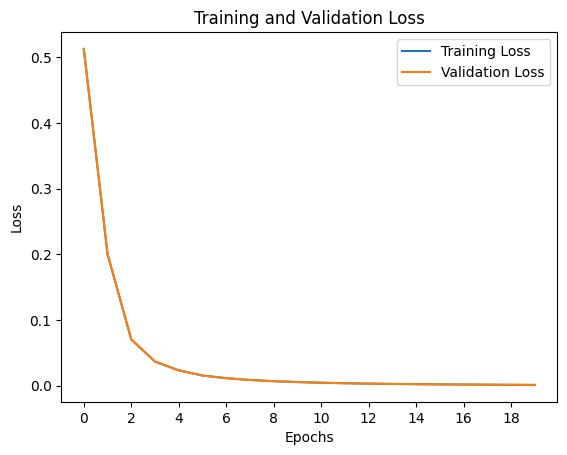

In [16]:
from matplotlib.pylab import plt
from numpy import arange
 
# Load the training and validation loss dictionaries
print(len(train_losses))
print(len(val_losses))
# Generate a sequence of integers to represent the epoch numbers
epochs = range(0, EPOCHS)
 
# Plot and label the training and validation loss values
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(arange(0, EPOCHS, 2))
 
# Display the plot
plt.legend(loc='best')
plt.show()

In [135]:
 # model.train()
    # tr_loss = 0
    # # getting the training set
    # print(train_x)
    # print(train_y)
    # print(train_x.shape)
    # print(train_y.shape)
    # x_train, y_train = Variable(torch.Tensor(train_x)), Variable(torch.Tensor(train_y))
    # # getting the validation set
    # x_val, y_val = Variable(val_x), Variable(val_y)
    # # converting the data into GPU format
    # if torch.cuda.is_available():
    #     x_train = x_train.cuda()
    #     y_train = y_train.cuda()
    #     x_val = x_val.cuda()
    #     y_val = y_val.cuda()

    # # clearing the Gradients of the model parameters
    # optimizer.zero_grad()
    
    # # prediction for training and validation set
    # output_train = model(x_train)
    # output_val = model(x_val)

    # # computing the training and validation loss
    # loss_train = criterion(output_train, y_train)
    # loss_val = criterion(output_val, y_val)
    # train_losses.append(loss_train)
    # val_losses.append(loss_val)

    # # computing the updated weights of all the model parameters
    # loss_train.backward()
    # optimizer.step()
    # tr_loss = loss_train.item()
    # if epoch%2 == 0:
    #     # printing the validation loss
    #     print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)

In [51]:
# defining the number of epochs
n_epochs = 25
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
for epoch in range(n_epochs):
  train(epoch)
print(train_losses)
print(val_losses)

NameError: ignored